In [1]:
import keras
from keras.layers import Conv2D, BatchNormalization, LeakyReLU, Add, MaxPooling2D, Dropout, concatenate, ZeroPadding2D, Conv2DTranspose
from keras.applications import Xception
from keras.models import Model

Using TensorFlow backend.


In [2]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [3]:
def UXception(input_shape=(None, None, 3),dropout_rate=0.5):

    backbone = Xception(input_shape=input_shape,weights='imagenet',include_top=False)
    input = backbone.input
    start_neurons = 16

    conv4 = backbone.layers[121].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="valid")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = residual_block(uconv4,start_neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[31].output
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[21].output
    conv2 = ZeroPadding2D(((1,0),(1,0)))(conv2)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[11].output
    conv1 = ZeroPadding2D(((3,0),(3,0)))(conv1)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(dropout_rate)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [4]:
model = UXception(input_shape= (400,400,3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [5]:
model.summary()

Model: "u-xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 199, 199, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 199, 199, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 199, 199, 32) 0           block1_conv1_bn[0][0]            
_________________________________________________________________________________________

In [6]:
#hyperparameters #50 -> 0.0001; 15 -> 0.00001;
EPOCHS = 100
L_RATE = 0.0001
B_SIZE = 8
STEPS = 100 // B_SIZE

In [7]:
#defining the iou loss function
import keras.backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)

    return iou

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [8]:
optimizer = keras.optimizers.adam(L_RATE)
#model.compile(optimizer= optimizer, loss= soft_dice_loss, metrics= [iou_coef, dice_coef])
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
from DataGenerator import DataGenerator

val_split=.0
data = DataGenerator(val_split=val_split)
if val_split != .0:
    valid_set = data.return_validation_set()

 13%|█▎        | 13/100 [00:00<00:00, 121.63it/s]

Reading images...


100%|██████████| 100/100 [00:00<00:00, 127.31it/s]

Done!


In [10]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor='acc', patience=3, mode='max', factor=0.5)
early_stop = EarlyStopping(monitor='acc', mode='max', patience=10)
checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='acc', mode='max', save_best_only=True)

cbacks = [reduce_lr, early_stop, checkpoint]

In [11]:
if val_split != .0:
    model.fit_generator(generator=data.generator(B_SIZE), validation_data=valid_set, epochs=EPOCHS, steps_per_epoch=STEPS)
else:
    model.fit_generator(generator=data.generator(B_SIZE), epochs=EPOCHS, steps_per_epoch=STEPS, callbacks=cbacks)


Epoch 1/100
12/12 [==============================] - 40s 3s/step - loss: 1.0876 - acc: 0.4482
Epoch 2/100
12/12 [==============================] - 14s 1s/step - loss: 0.9528 - acc: 0.4795
Epoch 3/100
12/12 [==============================] - 15s 1s/step - loss: 0.7900 - acc: 0.5675
Epoch 4/100
12/12 [==============================] - 15s 1s/step - loss: 0.6143 - acc: 0.7208
Epoch 5/100
12/12 [==============================] - 14s 1s/step - loss: 0.4875 - acc: 0.8405
Epoch 6/100
12/12 [==============================] - 14s 1s/step - loss: 0.4084 - acc: 0.8903
Epoch 7/100
12/12 [==============================] - 15s 1s/step - loss: 0.3636 - acc: 0.9116
Epoch 8/100
12/12 [==============================] - 15s 1s/step - loss: 0.3272 - acc: 0.9194
Epoch 9/100
12/12 [==============================] - 15s 1s/step - loss: 0.3082 - acc: 0.9261
Epoch 10/100
12/12 [==============================] - 15s 1s/step - loss: 0.2801 - acc: 0.9316
Epoch 11/100
12/12 [==============================] - 15s 

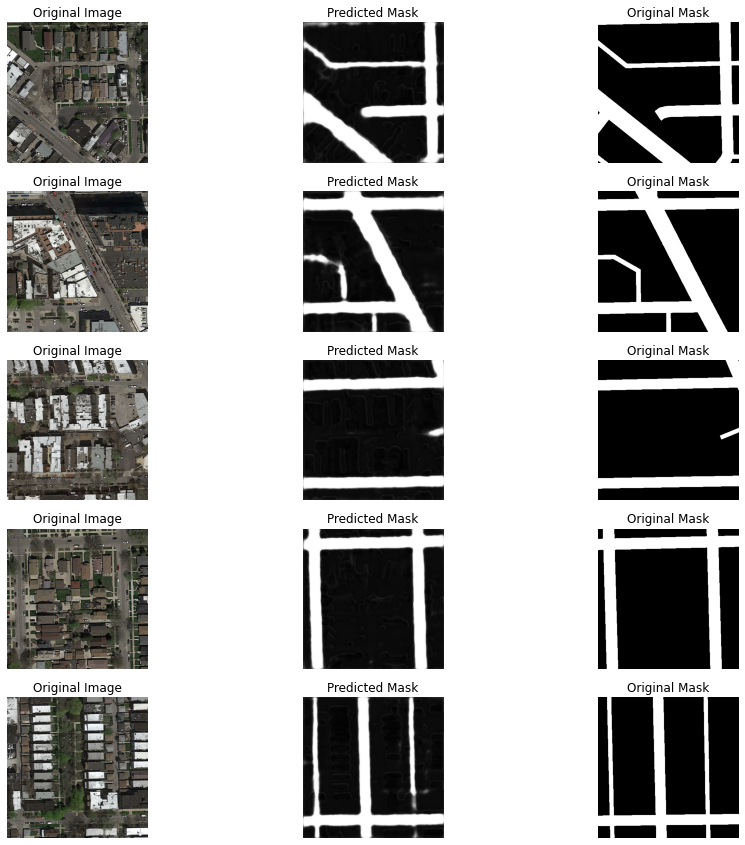

In [16]:
from visualization import display_predictions
import matplotlib.pyplot as plt

plt.figure(figsize= (15, 15))
gen = data.generator(30)
batch = next(gen)

display_predictions(batch[0], model.predict(batch[0]), batch[1])

In [17]:
from Labelizer import Labelizer

In [18]:
labelizer = Labelizer()

In [22]:
if val_split == .0:
    valid_set = next(data.generator(len(data.images)))
groundtruths = labelizer.make_submission(valid_set[1])[0]

In [23]:
val_predictions = model.predict(valid_set[0]).reshape(-1, 400, 400,)

In [24]:
predictions_labs = labelizer.make_submission(val_predictions)[0]

In [25]:
from sklearn.metrics import accuracy_score

accuracy_score(groundtruths, predictions_labs)

0.96464

In [26]:
model.save("model-unet-xception.h5", overwrite=True, include_optimizer=False)